In [1]:
import numpy as np
import pandas as pd

from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
 
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline


import xgboost as xgb
import statistics

from matplotlib import pyplot as plt
from matplotlib import widgets
%matplotlib widget

plt.style.use('seaborn')

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

C:\Users\mrgli\AppData\Local\Temp\ipykernel_24100\143430452.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Abbreviations
- OMG — optomiography  
- id - the target variable
- state - the gesture, the dscription of the above 'id'

# Data

In [2]:
# palm_file = './data/2024-12-13_20-00-16.emg8'
# palm_file = './data/2024-12-13_19-53-58.emg8'
palm_file = './data/2024-12-13_19-48-48.emg8'

df = pd.read_csv(palm_file, sep=' ')

In [3]:
GESTURES = df['state'].unique()
df['id'] = df['state'].replace({gesture: i for i, gesture in enumerate(GESTURES)})
df = df[df.id !=0]                  # избавляемся от технологического шума...
df = df[df.id !=9].reset_index()    # наш набор данный готов!

In [4]:
# GESTURES = ['Neutral', 'ThumbFingers','Close', 'Open', 'Pinch','Indication','Wrist_Flex','Wrist_Extend']

In [5]:
OMG_CH = ['omg0','omg1','omg2','omg3','omg4','omg5','omg6','omg7','omg8','omg9','omg10','omg11','omg12','omg13','omg14','omg15']
ST_TS_CH = ['state', 'ts','id','prot']

In [6]:
# Разделяем набор данных для преобразоваваний и Целевую группу..
df1 = df[OMG_CH]
df2 = df[ST_TS_CH]
y = df['id']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


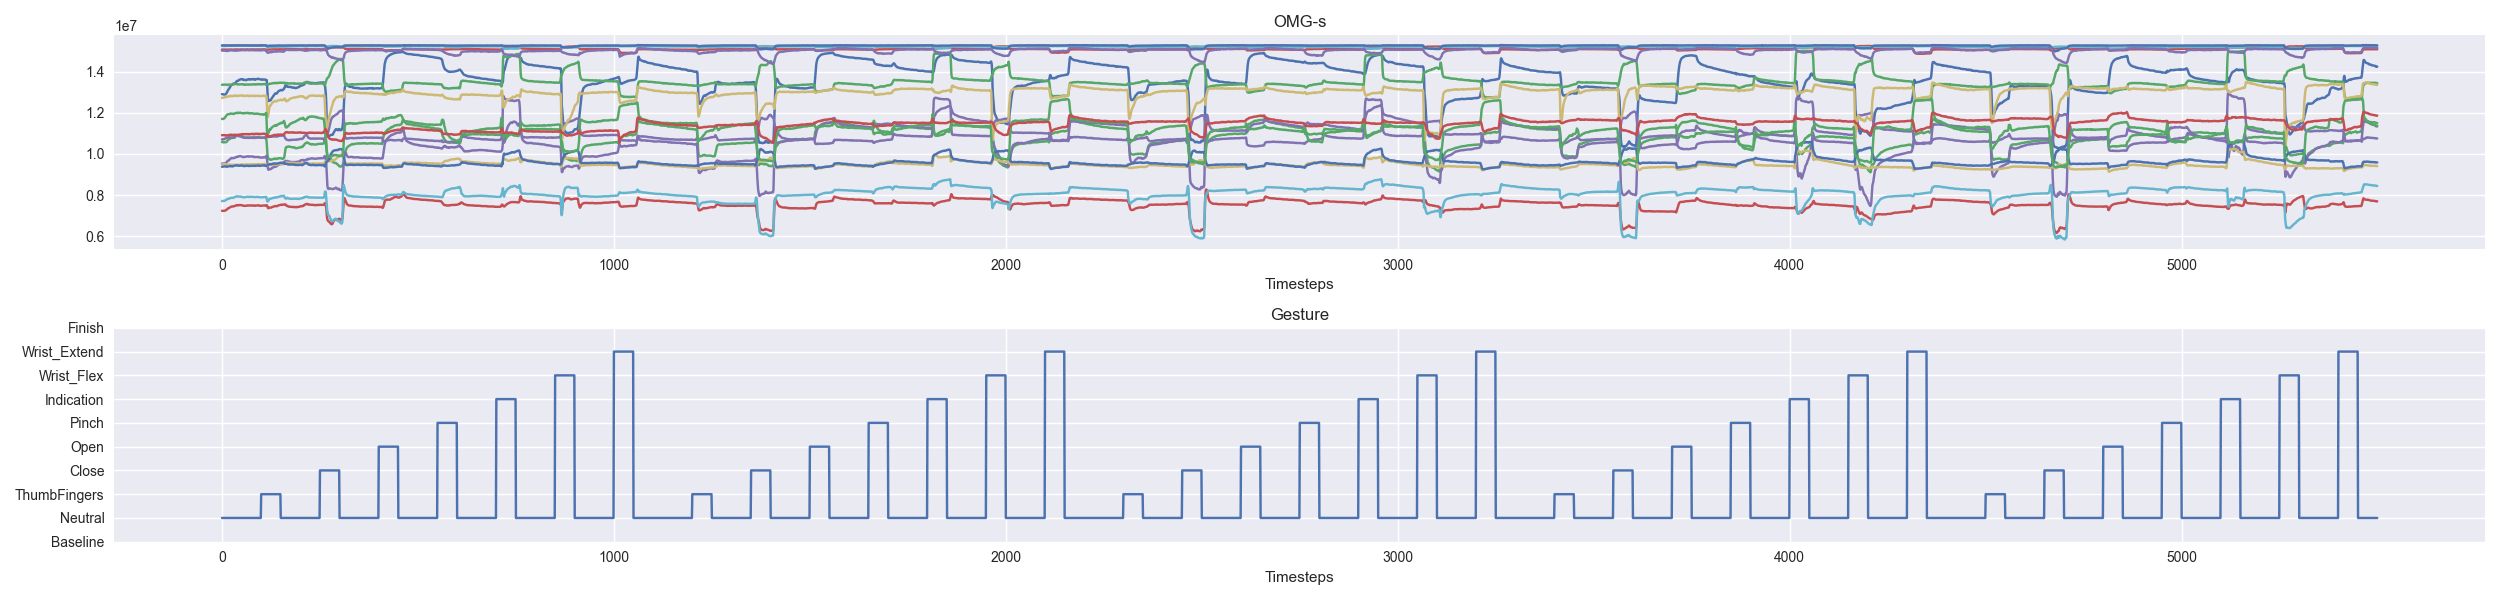

In [7]:
fig, axs = plt.subplots(2,1,figsize=(25, 6))

plt.sca(axs[0])
plt.plot(df1)
plt.title('OMG-s')
plt.xlabel('Timesteps')
plt.tight_layout()
plt.legend()

plt.sca(axs[1])
plt.plot(y)
plt.title('Gesture')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.tight_layout()
plt.legend()

In [8]:
class DropHiCorr(TransformerMixin,BaseEstimator):
    ''' Убирает высококоррелированные признаки (>0.85)'''

    def __init__(self):
        '''Здесь прописывается инициализация гиперпараметров, не зависящих от данных.'''
        pass
    
    def fit(self, X, y=None):
        '''
        Здесь прописывается «обучение» трансформера.
        Вычисляются необходимые для работы трансформера параметры (если они нужны).
        '''
        return self
    
    def transform(self, df):
        '''
        Здесь прописывается «обучение» трансформера.
        Вычисляются необходимые для работы трансформера параметры (если они нужны).
        '''
        corr_matrix = df.corr().abs()             # Найдем индекс столбцов с корреляцией >0.85
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))         # Выбираем верхний треугольник корреляционной матрицы
        to_drop = [column for column in upper.columns if any(upper[column] > 0.85)] 
        df.drop(to_drop,axis=1, inplace=True)
        return df


### Функция смещения целевой переменной

In [9]:
# создадим словарь {код замера (prot):Кол-во периодов смещения}  

def shifter(df_1,df_2,y):    
    shift_summary = {}
    y_shifted = y.copy()
    
    def scanner(df_1, df_2, sync):
        var=[] # дисперсия
        n=0
        grad=[] # градиент
        incr = 5
        
        df_temp0 = df_2[df_2['prot'] == sync]                   # отсортировываем этот Замер
        min, max = df_temp0.index.min(), df_temp0.index.max()
        min_ext, max_ext = (min - incr), (max - incr)           # чуть расширяем выборку для визуализации..
    
        XX = df_1[min_ext:max_ext]                              # - это наш набор данных...
    
        for i in range(XX.shape[0]):                                   # [min_ext:max
            # data_subset = XX.loc[i:i+incr]
            # if not data_subset.empty and len(data_subset) > 1:
                # var.append(statistics.pvariance(data_subset.values.flatten()))
            var.append(statistics.variance(XX[0:i+incr].flatten()))       # <== [0]
        
        for i in range(len(var)):
            g = np.gradient(var[0:i+incr])[-1]
            grad.append(g)
      
        for g in grad:
            if g < (np.mean(grad) + np.std(grad)):
                n +=1
            else:
                break
        return n    
    
    for i in list(set(df_2['prot'])):
        if df_2[df_2['prot']==i]['id'].mean() != 1:
            shift_summary[i] = scanner(df_1, df_2, sync=i) #всегдя используем df15 для отработки Смещения
        else:
            continue

    for i in shift_summary.keys():
        start, end = df_2[df_2['prot']==i].index.min(), df_2[df_2['prot']==i].index.max()
        gest = df_2.loc[end]['id']
        
        y_shifted[start:start + shift_summary[i]] = 1
        y_shifted[start + shift_summary[i]:(end + shift_summary[i])] = gest
    
    return y_shifted

### PIPELINE

In [10]:
# пайплайн для расчета сдмещения
pipe_preprop = Pipeline([  
            ('DropHiCorr', DropHiCorr()),
            ('Kbest',SelectKBest(f_classif, k=10)),
            ('scaler',StandardScaler()),
            ('pca',PCA(n_components=1))
        ])
# Обучение пайплайна
df15 = pipe_preprop.fit_transform(df1,y)

In [11]:
# генерируем сдвиг целевой переменной для устранения смещения
y_shifted = shifter(df15,df2,y)

In [16]:
# пайплайн для подготовки данных для модели...

pipeline_model = Pipeline([  
            ('DropHiCorr', DropHiCorr()),
            # ('Kbest',SelectKBest(f_classif, k=10)),
            ('scaler', MinMaxScaler()),
        ])
# Обучение пайплайна
# pipe_preprop.fit_transform(df1,y)

In [13]:
def scaler(df):
    from sklearn.preprocessing import StandardScaler
    
    # scaler = StandardScaler()
    scaler = MinMaxScaler()
    return scaler.fit_transform(df)

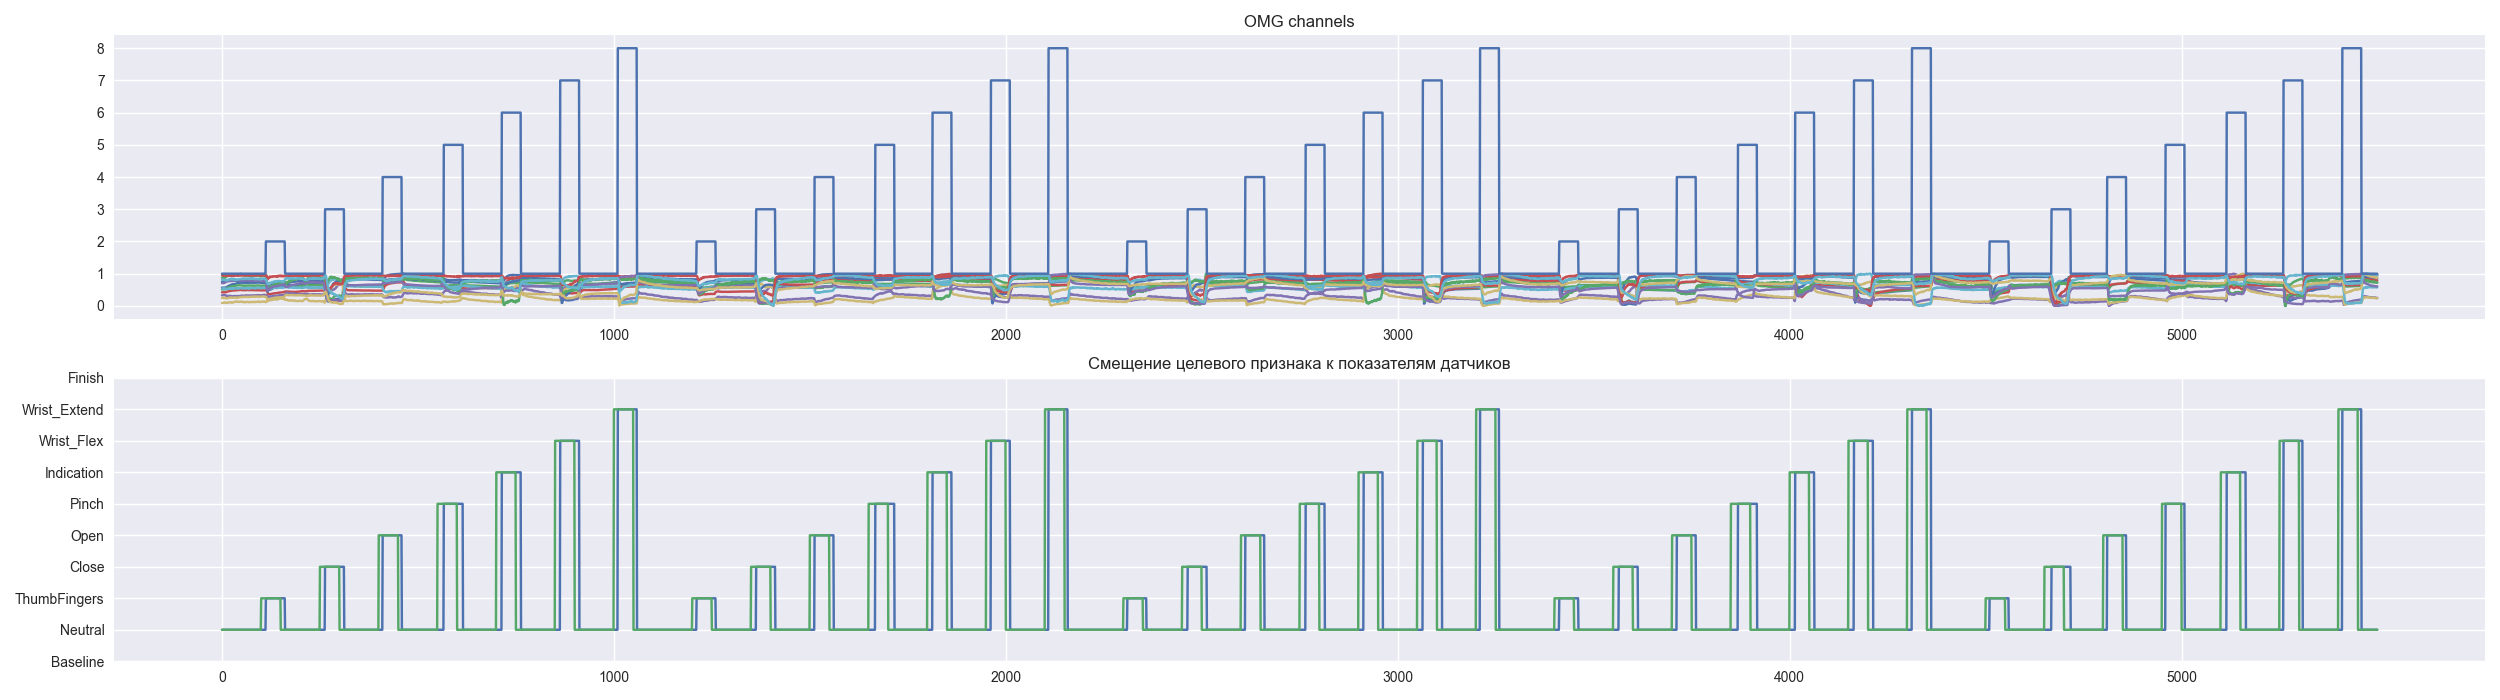

In [14]:
# Визуализация смещения...

fig, axs = plt.subplots(2,1,figsize=(25, 7))

minn = 0
maxx = 7500

plt.sca(axs[0])
plt.plot(scaler(df1)[minn:maxx])
plt.plot(y_shifted[minn:maxx])
plt.title('OMG channels')
# plt.xlabel('Timesteps')
plt.tight_layout()

plt.sca(axs[1])
plt.plot(y_shifted[minn:maxx])
plt.plot(y[minn:maxx])
plt.title('Смещение целевого признака к показателям датчиков')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.tight_layout()

### Define Train Data and the Target Value

In [ ]:
# определяем данные и целевую переменную для модели...
X = pipeline_model.fit_transform(df1,y)
y = y_shifted

# Train-test split

In [30]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# As suggested by Motorica = временные ряды!
last_train_idx = 4425   #int(round(X.shape[0]*0.7,0)) - 4425 оставляет последнюю серию жестов для тестирования модели...

X_train = X[:last_train_idx]
y_train = y[:last_train_idx]

X_test = X[last_train_idx:]
y_test = y[last_train_idx:]
# t_discretized = t_discretized[last_train_idx:] 

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4425, 12) (4425,)
(1075, 12) (1075,)


# Modeling

In [31]:
# соберем небольшой отчет для сравнения моделей
report = {}
def get_score(y_test, y_pred):
    f1 = metrics.f1_score(y_test, y_pred,average='weighted')
    print(f'F1 for Test: {f1:.4f}')
    print(f'Accuracy for Test: {metrics.accuracy_score(y_test, y_pred):.4f}')
    return f1

### Stacking

In [32]:
# Variant 1 - Kaggle ref - SB version 2_2_1 11-oct-24

estimators = [('rf', RandomForestClassifier(random_state=42,n_estimators=60,criterion='entropy')),
            ('KN', KNeighborsClassifier(n_neighbors=5)),    
            ('gnb', GaussianNB())
            ]

stack = StackingClassifier(estimators,
    final_estimator=xgb.XGBClassifier(random_state=42))

stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

# get_score(y_test, y_pred)
report['Stacking'] = f'F1 = {get_score(y_test, y_pred):.4f}'


F1 for Test: 0.9292
Accuracy for Test: 0.9293


### Stacking 2

In [33]:
# тоже, но без KNeighbors, так как Наивный Байес показывает себя неплохо...

estimators = [('rf', RandomForestClassifier(random_state=42,n_estimators=60,criterion='entropy')),
            # ('KN', KNeighborsClassifier(n_neighbors=5)),    
            ('gnb', GaussianNB())
            ]

stack = StackingClassifier(estimators,
    final_estimator=LogisticRegression(multi_class='multinomial',max_iter=5000, penalty='l2', solver='lbfgs')
    #xgb.XGBClassifier(random_state=42)
    )

stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

report['Stacking2'] = f'F1 = {get_score(y_test, y_pred):.4f}'

F1 for Test: 0.9504
Accuracy for Test: 0.9507


### Logistics Regression ###

In [34]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='multinomial',max_iter=5000, penalty='l2', solver='lbfgs')

lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

report['Logistics Regressioin'] = f'F1 = {get_score(y_test, y_pred_lr):.4f}'

F1 for Test: 0.9161
Accuracy for Test: 0.9228


### Наивный Байес

In [35]:
classifier = GaussianNB()
classifier.fit(X_train,y_train)
y_pred_nb = classifier.predict(X_test)

report['Naive Bayes'] = f'F1 = {get_score(y_test, y_pred_nb):.4f}'

F1 for Test: 0.8821
Accuracy for Test: 0.8679


### Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42,n_jobs=-1,max_depth=6,criterion='log_loss',oob_score=True,n_estimators=90,min_samples_leaf=4)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

report['Random Forest'] = f'F1 = {get_score(y_test, y_pred_rf):.4f}'
rf.oob_score_

F1 for Test: 0.9344
Accuracy for Test: 0.9367


0.9751412429378531

### Report

In [37]:
df_report = pd.DataFrame.from_dict(report,orient='index')
df_report

,0
Stacking,F1 = 0.9292
Stacking2,F1 = 0.9504
Logistics Regressioin,F1 = 0.9161
Naive Bayes,F1 = 0.8821
Random Forest,F1 = 0.9344


## Prediction

In [42]:
# сюда нужно подставить лучшую модель...
y_pred_train = stack.predict(X_train)
y_pred_test = pd.DataFrame(stack.predict(X_test),index=y_test.index)

Text(0.5, 1.0, 'Train')

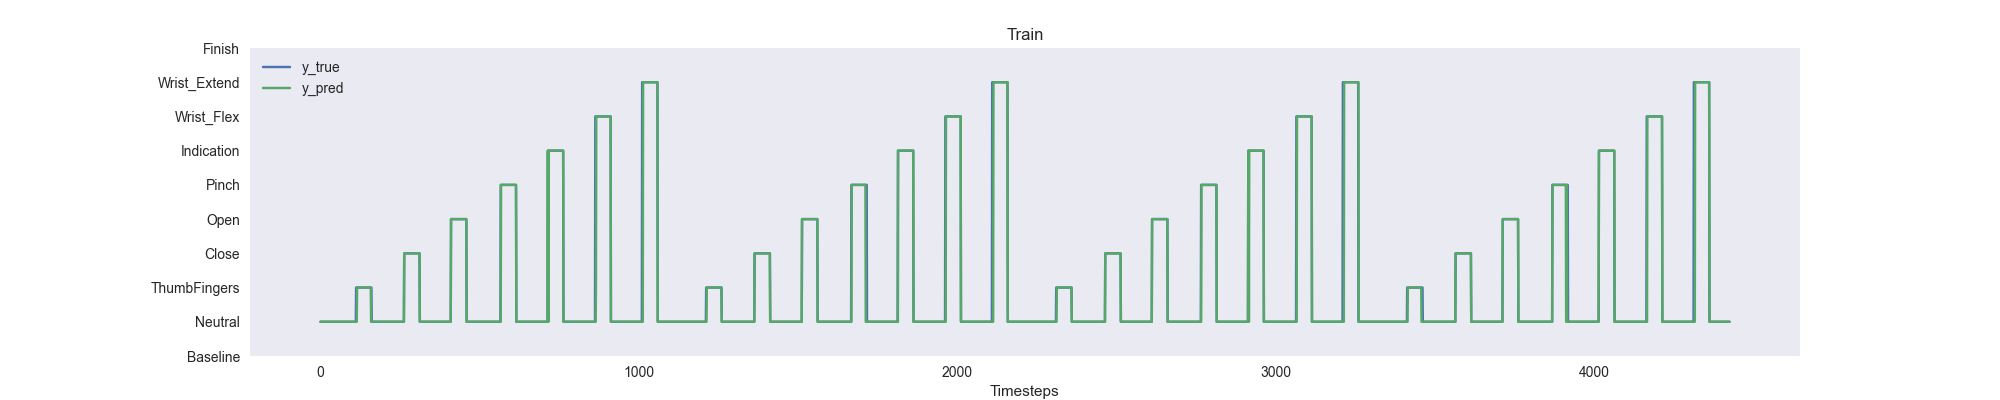

In [39]:
fig = plt.figure(figsize=(20, 4))
plt.plot(y_train,  c='C0', label='y_true')
plt.plot(y_pred_train, c='C1', label='y_pred')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')


Text(0.5, 1.0, 'TEST')

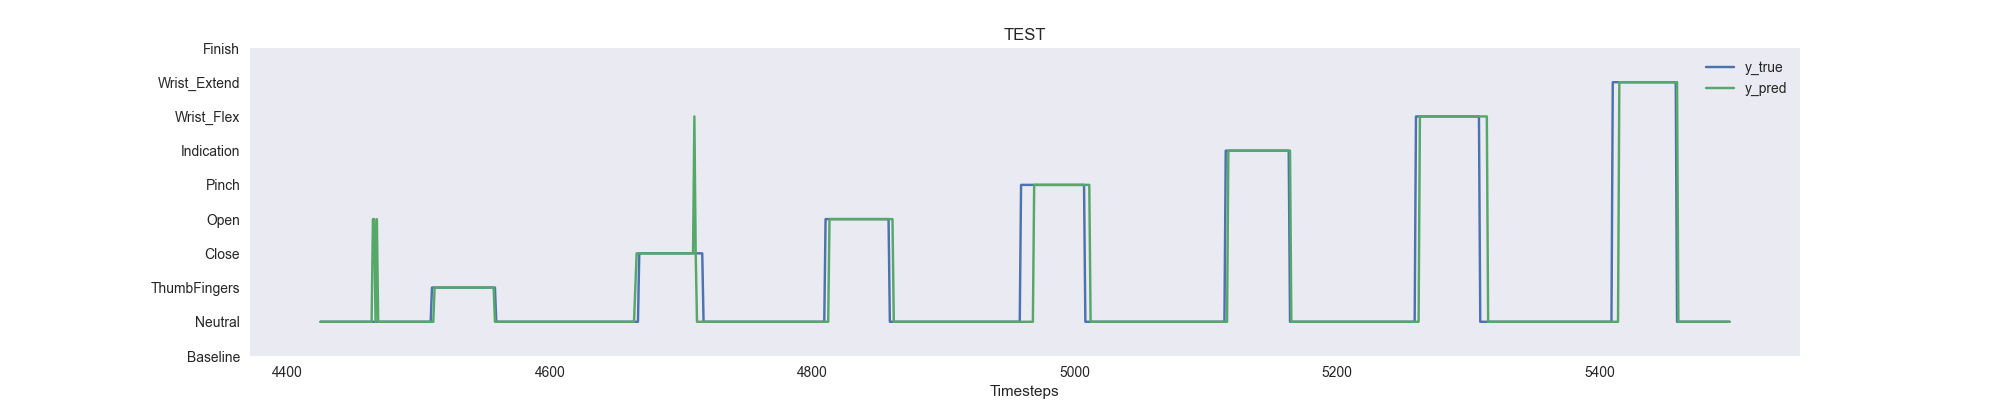

In [43]:
fig = plt.figure(figsize=(20, 4))
plt.plot(y_test,  c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('TEST')

## Metrics

In [44]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred_train)) #, target_names=GESTURES))
print(classification_report(y_test, y_pred_test)) #, target_names=GESTURES))

              precision    recall  f1-score   support

           1       0.98      1.00      0.99      3053
           2       0.99      0.92      0.96       196
           3       1.00      1.00      1.00       196
           4       1.00      1.00      1.00       196
           5       1.00      0.94      0.97       196
           6       1.00      0.98      0.99       196
           7       1.00      0.95      0.98       196
           8       0.99      0.92      0.96       196

    accuracy                           0.99      4425
   macro avg       1.00      0.96      0.98      4425
weighted avg       0.99      0.99      0.99      4425

              precision    recall  f1-score   support

           1       0.96      0.97      0.96       732
           2       0.98      0.94      0.96        49
           3       0.96      0.88      0.91        49
           4       0.88      0.94      0.91        49
           5       0.91      0.80      0.85        49
           6       0.98 

# Real-time inference

In [ ]:
import time
import serial
from IPython.display import clear_output

In [ ]:
# def get_crc(data, count):
#     result = 0x00
#     l = count
#     while (count>0):   
#         result = crc_table[result ^ data[l-count]]
#         count -= 1;
#     return result;

# def drv_abs_one(ser, control):
#     if ser is None:
#         return
#     pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
#     pack[-1] = get_crc(pack[1:], 9)
#     return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [ ]:
%%time

df14 = get_pca(scaler(drop_outliers(df1[get_Kbest(df1,y)[1]])))
y_pred = stack.predict(df14)

f1 = metrics.f1_score(y, y_pred, average='weighted')
print(f'F1 score for Test is {f1:.4f}')
print(f'Accuracy for Test: {metrics.accuracy_score(y, y_pred)}')

In [1]:
# x = df_guest[df_guest['prot']==15] - to be canceled!...

In [ ]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = stack.predict([x])
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [ ]:

df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

In [ ]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        td_ts, omg_sample, _ = np.array_split(sample, [2, 2 + N_OMG_CH])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample.astype(float))
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    # NO COMMANDS forming IN SIMULATION
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        # sanity check: Sizes of SAMPLE=65, OMG=16
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}', end='             \r')
    
    ts_diff = time.time() - ts_start
    # assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

In [ ]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'].argmax(axis=1), c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'].argmax(axis=1), c='C2', label='y_postprocessed')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [ ]:
print(classification_report(y_test, y_dct['y_postprocessed'].argmax(axis=1), target_names=GESTURES))

### Online

### Virtuel hand

In [ ]:
import VirtualPhantom
vp = VirtualPhantom.VirtualPhantomClient('localhost', 1755)

In [ ]:
# Bindings for virtual hand
def commands(x):
    cmd = vp.neutral_state.copy()
    # for this mapping look at GESTURES
    if x == 0: # Pilot Neutral
        pass # Do nothing
    elif x == 1: # Pilot thumb_fingers
        # Virtual Hand thumb_fingers
        cmd.update({'thumb_flex': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
    elif x == 2: # Pilot close_state
        # Virtual Hand close_state
        cmd.update({'thumb_flex': 1, 'index_flex': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
    elif x == 3: # Pilot open_state
        cmd.update({'thumb_extend': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
    elif x == 4: # Pilot pinch_state
        cmd.update({'thumb_flex':1, 'index_flex': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
    elif x == 5: # Pilot indication_state
        cmd.update({ 'thumb_extend':1, 'index_extend': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
    elif x == 6: # Wrist_Flex
        cmd.update({'wrist_flex': 1})
    elif x == 7: # Wrist_Extend
        cmd.update({'wrist_extend': 1})
    else:
        pass # Do nothing
    
    return cmd

In [ ]:
!ls /dev/ttyACM* /dev/ttyUSB*

In [ ]:
ser_name = '/dev/ttyACM0'
try:
    ser.close()
except:
    pass
ser = serial.Serial(ser_name, baudrate=115200, timeout=60);

ser.write('PT1\r\n'.encode())
time.sleep(0.1)
ser.write('Pt1\r\n'.encode())
time.sleep(0.1)
ser.flush()
time.sleep(0.1)

def parseline():
    line = ser.readline().decode().replace('\n', '')
    data = np.array(list(filter(len, np.array(line.split(" "))))).astype(float)
    return data

In [ ]:
TIMEOUT = 0.033
DEBUG = True

while(ser.in_waiting>50):
    ser.readline()
    time.sleep(0.005)
ser.readline()
    
t_start = time.time()
prev_idx = -1

y_previous = None
while True:    
    
    # [Data reading]
    t_rel = time.time() - t_start
    
    try: 
        data = parseline()
        data_line = ' '.join(data.astype(str))
        data_line += f' {-1} {"Inference"} {-1} {t_rel:.2f}'
    except Exception as e:
        raise(e)
        data_line = ' '.join(['-1']*n_cols)
        data_line += f' {-1} {"Error"} {-1} {t_rel:.2f}'

    td_ts, omg_sample, _ = np.array_split(data, [2, 2 + N_OMG_CH])        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed   = preprocessing(omg_sample.astype(float))
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted           = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed       = postprocessing(y_predicted, y_previous)
    y_postprocessed_label = y_postprocessed.argmax()
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed_label)
    # [/Commands composition]
    
    # [Commands sending]
    prot_idx = deepcopy(y_postprocessed_label)
    if (prot_idx != prev_idx):
        vp.send_cmd(**y_commands)
        prev_idx = deepcopy(prot_idx)
    # [/Commands sending]
    
    # [Data logging]
    # [/Data logging]

    y_previous = y_postprocessed.copy()
    time.sleep(0.001)
    t_rel = time.time() - t_start
    
    if DEBUG:
        # sanity check: Sizes of SAMPLE=65, OMG=16
        # print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}', end='             \r')
        # print(GESTURES[y_postprocessed_label], sample_preprocessed.tolist(), end='             \r')
        print(GESTURES[y_postprocessed_label], y_predicted, end='             \r')
    
    # assert(t_rel<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'